Compare consumption profile before and consumption profile after. See clustering of consumption in 2019, 2018, 2020. Consumption profile. Need to find pattern which make the transformation from temporal representation to space representation possible. Temporal sequence clustering(check). How to identify temporal patterns? 

In [1]:
import pandas as pd
import numpy as np
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import os
from torchvision.utils import save_image
from torch.autograd import Variable
from os.path import exists
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
from html2image import Html2Image

def save_table_as_pic(df, name):
    dict_data = [df.to_dict(), df.to_dict('index')]
    htmldf = '<!DOCTYPE HTML><html><head><meta http-equiv="Content-Type" content="text/html; charset=utf-8"></head><body>'

    htmldf = htmldf + '<table  width="auto" ><tr>'

    for key in dict_data[0].keys():
        htmldf = htmldf + '<th class="header" height="30px" style="font-weight: bold; background-color: #C0C9CC; padding: 15px;">' + key + '</th>'

    htmldf = htmldf + '</tr>'

    for key in dict_data[1].keys():
        htmldf = htmldf + '<tr height="30px"'
        htmldf = htmldf + 'style="padding: 5px;" >' if key % 2 == 0 else htmldf + 'style="background-color: #F2F1F0; padding: 5px;">'
        for subkey in dict_data[1][key]:
            htmldf = htmldf + '<td style="padding: 5px;">' + str(dict_data[1][key][subkey]) + '</td>'
        htmldf = htmldf + '</tr>'
    htmldf = htmldf + '</tr>'
    htmldf = htmldf + '</tr></table></body></html>'

    with open(name+'.html','wb') as f:
        f.write(htmldf.encode("utf-8"))

# Prepare data

In [3]:
main_df = pd.read_csv('data/dataset.csv', low_memory=False)
main_df.head(5)

,Year,Month,Consumer_number,Consumer_type,Installation_zone,Consumption,Installation_number
0,2013,1,21018,1,4,0,NaN
1,2013,1,36690,2,6,5,NaN
2,2013,1,17940,1,6,6,NaN
3,2013,1,14273,1,6,1,NaN
4,2013,1,5,1,6,13,NaN


In [72]:
monthes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
years = [2013, 2014, 2016, 2017, 2018, 2019, 2020]
colors = ['#023047', '#ffb703', '#8ecae6','#f1c0e8', '#f72585', '#006d77', '#7400b8',  '#ef476f', 
          '#757bc8', '#001233', '#00f5d4', '#8ac926', '#ffca3a','#b7094c', '#8338ec', '#ffc6ff', 
          '#70e000', '#0d47a1']
# t = df_pivot.rename(columns={1: '1', 2:'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9', 10:'10', 11:'11', 12:'12'})
# save_table_as_pic(t.head(), 'cluster_cons_type')

In [80]:
consumer_types = pd.read_csv('data/consumer_types.csv', low_memory=False)
consumer_types.head()

,Consumer_type,Name
0,1,DOMÉSTICO
1,2,COM/INDUSTRIAL/OBRAS
2,3,UTIL.PUBLICA
3,4,OBRAS
4,5,ESTADO


In [55]:
#Create dataset for clustering

df = main_df[(main_df['Year'] == 2018) | (main_df['Year'] == 2019) | (main_df['Year'] == 2020)].drop(columns={'Year'})
df = df.drop_duplicates().fillna(0)
df= df.groupby(['Consumer_number', 'Month'], as_index = False).sum()
df = df.drop(df.index[0])
df.head(5)

,Consumer_number,Month,Consumer_type,Installation_zone,Consumption,Installation_number
1,1,4,3,4,31,3069.0
2,1,5,3,4,208,3069.0
3,1,6,3,4,245,3069.0
4,1,7,9,12,706,9207.0
5,1,8,3,4,308,3069.0


In [176]:
df_pivot = df.pivot(index = 'Consumer_number', columns = 'Month', values = 'Consumption').fillna(0)
df_pivot = df_pivot.rename_axis(None,axis=1).set_axis(monthes, inplace=False, axis=1).reset_index()
# df_pivot = df_pivot.loc[~df_pivot[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]].apply(lambda row: (row==0).all(), axis=1)]
df_pivot.head(5)

,Consumer_number,1,2,3,4,5,6,7,8,9,10,11,12
0,1,0.0,0.0,0.0,31.0,208.0,245.0,706.0,308.0,0.0,0.0,0.0,0.0
1,5,17.0,0.0,0.0,7.0,15.0,15.0,8.0,0.0,0.0,8.0,8.0,65.0
2,11,9.0,0.0,5.0,0.0,3.0,2.0,0.0,12.0,0.0,2.0,0.0,0.0
3,15,49.0,20.0,24.0,0.0,7.0,5.0,0.0,12.0,0.0,3.0,0.0,3.0
4,16,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,12.0,0.0,4.0,0.0


# Clustering

In [74]:
x = df_pivot.loc[:, monthes].values
# print('x shape:', x.shape)
y = df_pivot.loc[:,['Consumer_number']].values
# print('y shape:', y.shape)
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents,
              columns = ['x', 'y'])
principalDf.head()

,x,y
0,13.354842,5.078004
1,0.654862,-0.530561
2,-0.264844,-0.155529
3,0.551299,-0.811329
4,-0.204098,0.387780


In [75]:
resultDf = pd.merge(principalDf, df_pivot['Consumer_number'], left_index=True, right_index=True)
print(resultDf.head(5))

           x         y  Consumer_number
0  13.354842  5.078004                1
1   0.654862 -0.530561                5
2  -0.264844 -0.155529               11
3   0.551299 -0.811329               15
4  -0.204098  0.387780               16


In [205]:
clf = DBSCAN(eps=0.1, min_samples=8).fit(principalDf)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("\nClusters discovered: %d" % n_clusters_)

# fig = plt.figure(figsize=(10, 10))
# sns.scatterplot(principalDf['x'], principalDf['y'], hue=["cluster-{}".format(x) for x in labels])


Clusters discovered: 4


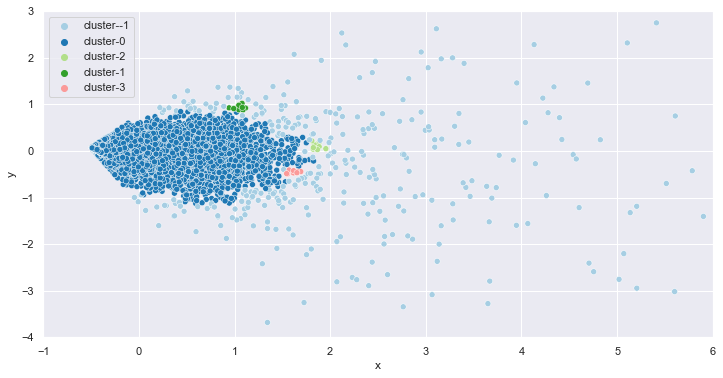

In [206]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(principalDf['x'], principalDf['y'], hue=["cluster-{}".format(x) for x in labels], palette="Paired")
plt.xlim([-1, 6])
plt.ylim([-4, 3])
plt.savefig("charts/dbscan/dbscan_pca_consumer.png", bbox_inches='tight')
plt.show()

# The consumer types in each cluster

In [79]:
label = pd.DataFrame({'Label': labels})
df_2 = resultDf.join(label).drop(columns={'x', 'y'})
df_2.head(5)

,Consumer_number,Label
0,1,-1
1,5,0
2,11,0
3,15,0
4,16,0


In [94]:
types = df.drop(columns=['Month', 'Installation_zone', 'Consumption', 'Installation_number'])
types = types.drop_duplicates()
types = pd.merge(types, consumer_types, left_on='Consumer_type', right_on='Consumer_type', how='inner')
types  = pd.merge(types, df_2, left_on='Consumer_number', right_on='Consumer_number', how='inner')
types = types.drop(columns={'Consumer_number'})
types ['Count'] = types ['Consumer_type']
types.head()

,Consumer_type,Name,Label,Count
0,3,UTIL.PUBLICA,-1,3
1,9,RURAL DOMÉSTICO,-1,9
2,3,UTIL.PUBLICA,0,3
3,2,COM/INDUSTRIAL/OBRAS,0,2
4,1,DOMÉSTICO,0,1


In [126]:
df_final = types.groupby(['Label','Name', 'Consumer_type'], as_index=False).agg({'Count':'count'})
df_final.loc[df_final["Label"] == -1, "Label"] = 8
df_final = df_final.rename(columns={'Label': 'Cluster'}).drop(columns=['Consumer_type'])
df_final.head()

,Cluster,Name,Count
0,8,COM/INDUSTRIAL/OBRAS,160
1,8,CP.COM/URB,1
2,8,CP.DOM/URB,1
3,8,DOM./RURAL A.S,5
4,8,DOMÉSTICO,206


In [128]:
df_pivot = pd.pivot(df_final, values='Count', index=['Cluster'], columns=['Name']).fillna(0)
df_pivot = df_pivot.rename_axis(None,axis=1).reset_index()

In [131]:
df_pivot_1 = df_pivot[~df_pivot['Cluster'].isin([0, 8])]
df_pivot_2 = df_pivot[df_pivot.Cluster == 0]
df_pivot_3 = df_pivot.loc[ (df_pivot.Cluster == 8)]

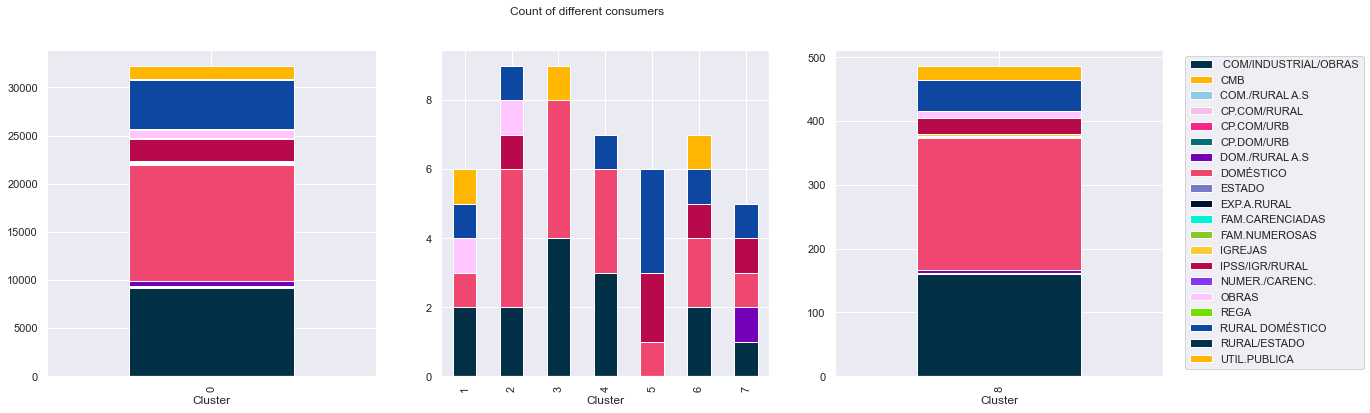

In [207]:
fig, axs = plt.subplots(ncols=3, figsize=(20,6))
df_pivot_2.plot(x = 'Cluster', kind='bar', stacked=True, color=colors, ax=axs[0]).legend().set_visible(False)
df_pivot_1.plot(x = 'Cluster', kind='bar', stacked=True, color=colors, ax=axs[1]).legend().set_visible(False)
df_pivot_3.plot(x = 'Cluster', kind='bar', stacked=True, color=colors, ax=axs[2]).legend(bbox_to_anchor=(1.05, 1))
 
fig.suptitle('Count of different consumers')
# plt.gca().set_aspect('equal', adjustable='box') 
plt.savefig("charts/dbscan/PCA_profile_consumer.png", bbox_inches='tight')
plt.show()